In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, WDiscriminator
from off_manifolder import offmanifolder_maker
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit, GeodesicBridge
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset


import hydra
from omegaconf import DictConfig, OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from procrustes import Procrustes
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# cfg_main_ae_sweep_id = '8jfjcnrt'
cfg_main_ae_sweep_id = 'ycgsbnib'
# cfg_main_ae_sweep_id = 'a9g00yzv'
cfg_main_disc_sweep_id = '1k78kgzf'
cfg_main_weights_cycle = 0.
cfg_main_dimensions_latent = 2

In [3]:
figg = make_subplots(
    rows=2, cols=3,
    specs=[
        [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}],
        [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]
    ],
    subplot_titles=(
        "GAGA", "GAGA", "GAGA",
        "PHATE", "HeatGeo (Harnack)", "HeatGeo (denoise)"
    )
)

In [4]:
# results_path = f'results/{cfg_main.data_name}/{cfg_main.dimensions_latent}'
# pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)
cfg_main_data_name = 'EB_phate'

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = cfg_main_ae_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = cfg_main_data_name
# run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == cfg_main_weights_cycle) & (df['dimensions.latent'] == cfg_main_dimensions_latent) & (df['cfg/loss/weights/reconstr']==0.01) & (df['cfg/loss/weights/dist']==77.4)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()

proc = Procrustes()
z1, z2, disp = proc.fit_transform(data['phate'], zc)
scatter(z2, data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='GAGA').show()
scatter(data['phate'], data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='PHATE').show()
gaga_phate, true_phate = z2, data['phate']

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [5]:
df['data.name'].unique()

array(['EB_heatgeo', 'EB_DiffusionMap', 'EB_heatgeo_Harnack.75',
       'EB_heatgeo_Denoise.5', 'EB_phate'], dtype=object)

In [6]:
cfg_main_data_name = 'EB_heatgeo_Harnack.75'

# results_path = f'results/{cfg_main.data_name}/{cfg_main.dimensions_latent}'
# pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = cfg_main_ae_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = cfg_main_data_name
# run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == cfg_main_weights_cycle) & (df['dimensions.latent'] == cfg_main_dimensions_latent) & (df['cfg/loss/weights/reconstr']==0.01) & (df['cfg/loss/weights/dist']==77.4)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()

proc = Procrustes()
z1, z2, disp = proc.fit_transform(data['phate'], zc)
scatter(z2, data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='GAGA').show()
scatter(data['phate'], data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='PHATE').show()
gaga_heatgeo_harnack, true_heatgeo_harnack = z2, data['phate']

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [7]:
cfg_main_data_name = 'EB_heatgeo_Denoise.5'

# results_path = f'results/{cfg_main.data_name}/{cfg_main.dimensions_latent}'
# pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = cfg_main_ae_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = cfg_main_data_name
# run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == cfg_main_weights_cycle) & (df['dimensions.latent'] == cfg_main_dimensions_latent) & (df['cfg/loss/weights/reconstr']==0.01) & (df['cfg/loss/weights/dist']==77.4)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()

proc = Procrustes()
z1, z2, disp = proc.fit_transform(data['phate'], zc)
scatter(z2, data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='GAGA').show()
scatter(data['phate'], data['colors'], s=3, white_bkgrnd=True, ticks=False, rescale=True, title='PHATE').show()
gaga_heatgeo_denoise, true_heatgeo_denoise = z2, data['phate']

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



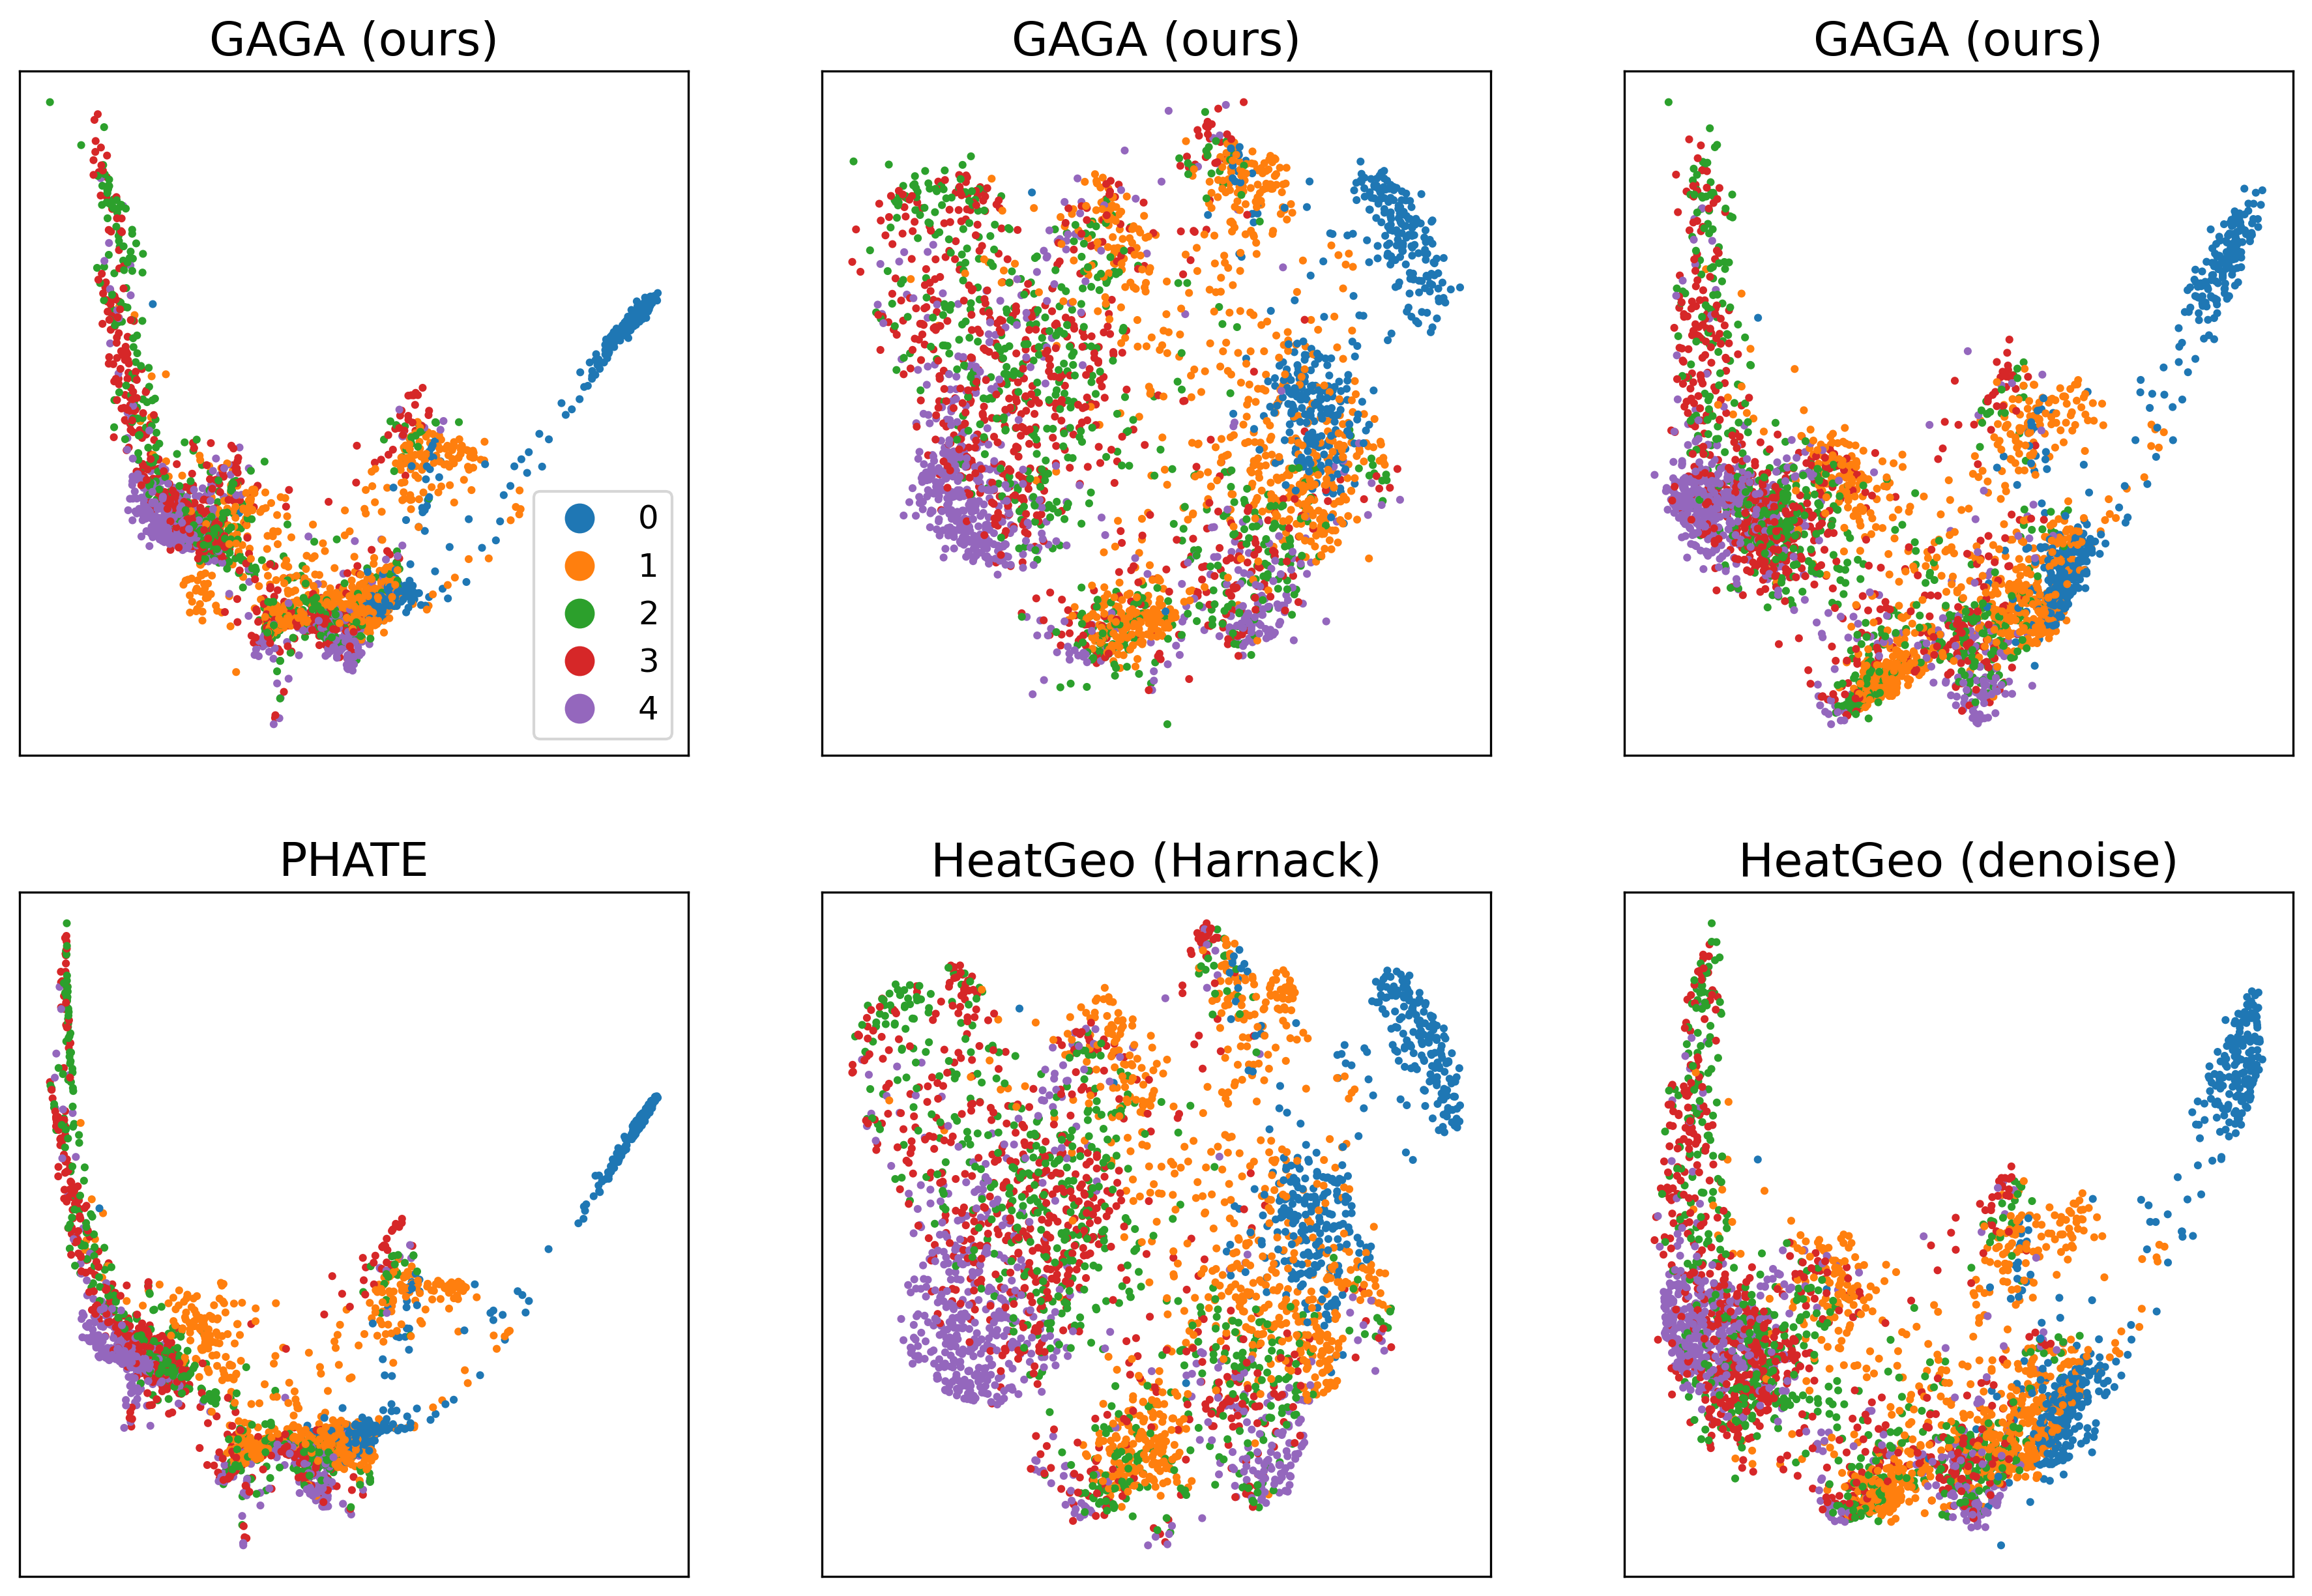

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
scprep.plot.scatter2d(gaga_phate, c=data['colors'], ax=ax[0, 0], ticks=False, title='GAGA (ours)', legend=True)
scprep.plot.scatter2d(true_phate, c=data['colors'], ax=ax[1, 0], ticks=False, title='PHATE', legend=False)
scprep.plot.scatter2d(gaga_heatgeo_harnack, c=data['colors'], ax=ax[0, 1], ticks=False, title='GAGA (ours)', legend=False)
scprep.plot.scatter2d(true_heatgeo_harnack, c=data['colors'], ax=ax[1, 1], ticks=False, title='HeatGeo (Harnack)', legend=False)
scprep.plot.scatter2d(gaga_heatgeo_denoise, c=data['colors'], ax=ax[0, 2], ticks=False, title='GAGA (ours)', legend=False)
scprep.plot.scatter2d(true_heatgeo_denoise, c=data['colors'], ax=ax[1, 2], ticks=False, title='HeatGeo (denoise)', legend=False)
plt.savefig('EB.pdf')

In [9]:
plot_dict = dict(
    colors=data['colors'],
    gaga_phate=gaga_phate,
    true_phate=true_phate,
    gaga_heatgeo_harnack=gaga_heatgeo_harnack,
    true_heatgeo_harnack=true_heatgeo_harnack,
    gaga_heatgeo_denoise=gaga_heatgeo_denoise,
    true_heatgeo_denoise=true_heatgeo_denoise
)
import pickle
with open('figure3_EB_embeddings.pkl', 'wb') as f:
    pickle.dump(plot_dict, f)